# Import the necessary libraries

In [19]:
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import sample
import warnings
warnings.filterwarnings('ignore')

# Visualizing direction of maximum variance

**1. First we generate a set of points inside an ellipse** 

In [20]:
def generatePointsOnEllipse(maj_axis,min_axis,centre,tilt,pointNum):
    
    u_x = centre[0]  ## X_co-ordinate of the centre
    u_y = centre[1]  ## Y_co-ordinate of the centre
    
    tilt_rad = tilt*np.pi/180 ## Convert the angle of the centre in radians
    
    rot_matrix = np.array([[np.cos(tilt_rad), np.sin(tilt_rad)]
                           ,[-np.sin(tilt_rad), np.cos(tilt_rad)]])  ## This rotation matrix will rotate the points in clockwise direction
    
    gen_Points = 0 ## Number of points generated inside the ellipse so far 
    
    a = maj_axis/2 ## Semi-major axis 
    b = min_axis/2 ## Semi-minor axis
    
    internal_points = []
    while(gen_Points<pointNum):
        x = np.random.uniform(-a,a)
        y = np.random.uniform(-b,b)
        if((x/a)**2+(y/b)**2 < 1):
            internal_points.append([x,y])
            gen_Points +=1
    internal_points = np.matrix(internal_points) ##Convert the list of points to a matrix
    internal_points = internal_points@rot_matrix  ## Rotate the matrix by the angle 'tilt_rad'
    
    x_val = np.ravel(internal_points[:,0]) ## Convert the 1-D matrix to a 1-D array using np.ravel
    y_val = np.ravel(internal_points[:,1]) ## Convert the 1-D matrix to a 1-D array using np.ravel
    
    x_val = x_val + u_x   ## Shift the centre of the ellipse to [u_x,u_y]
    y_val = y_val + u_y   ## Shift the centre of the ellipse to [u_x,u_y]
    plt.scatter(x_val,y_val,s=10)
    plt.show()
    return(x_val,y_val)

**2. Then we visualize our set of points**

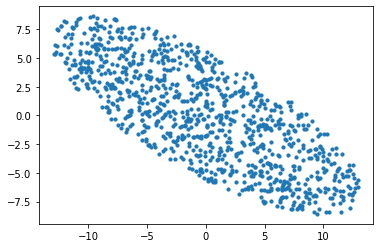

In [21]:
x_val,y_val = generatePointsOnEllipse(30,10,[0,0],150,1000)

**3. We calculate the eigen-vectors of the covariance matrix of these set of points**

In [4]:
data_mat = np.stack((x_val,y_val)) ## np.stack is used to stack multiple 1-d arrays
print(data_mat)

cov_mat = np.cov(data_mat) ## Obtain the covariance matrix of the data vector
eig_val, eig_vec = np.linalg.eig(cov_mat) ## Find the eigen vectors and the corresponding eigen values of the matrix

print("Eigen values for this dataset is {}".format(eig_val)) ## Print these eigen values 
print("Corresponding eigen-vectors are {}".format(eig_vec)) ## ith column of this matrix is the eigen vector corresponding the ith eigen value 

eig_1 = eig_vec[:,0]
eig_2 = eig_vec[:,1]
data_mean = np.mean(data_mat,axis=1) ## Compute the row-wise mean for this dataset
data_shift = data_mat - np.matrix(data_mean).T ## Converts X to (X-mu)

[[-13.06025275 -10.40034108  -8.69782899 ...   2.1293963    7.66926917
    7.24229415]
 [  6.7667326    2.83640785   1.19263212 ...   2.08608661  -2.85775079
   -2.45212467]]
Eigen values for this dataset is [58.16112236  6.00744405]
Corresponding eigen-vectors are [[ 0.87059806  0.49199494]
 [-0.49199494  0.87059806]]


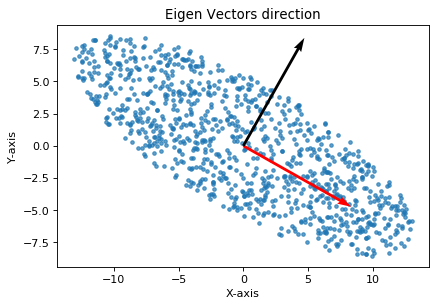

In [5]:
origin = [0], [0] # origin point

plt.figure(dpi=80)
plt.title("Eigen Vectors direction")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.scatter(x_val,y_val,s=10,alpha=0.7)
plt.quiver(*origin, eig_vec[0,:], eig_vec[1,:], color=['red','black'], scale=3)
plt.show()

**4. Project the set of points along the direction of eigen vectors and calculate the variances of these projected points** 

In [6]:
eig_1_mat = np.matrix(eig_1)
proj_points_1 = eig_1_mat@data_shift
print("Variance of the projected points along 1st eigen vector is {}".format(np.var(proj_points_1)))

eig_2_mat = np.matrix(eig_2)
proj_points_2 = eig_2_mat@data_shift
print("Variance of the projected points along 2nd eigen vector is {}".format(np.var(proj_points_2)))

Variance of the projected points along 1st eigen vector is 58.10296124043988
Variance of the projected points along 2nd eigen vector is 6.001436604964919


# PCA on Yale Faces Dataset

**Display some of the images from the dataset**

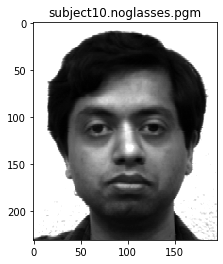

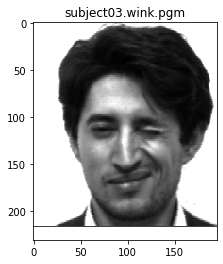

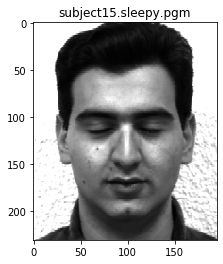

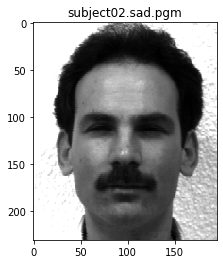

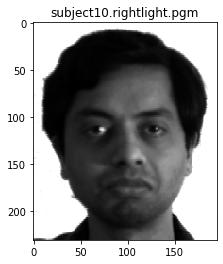

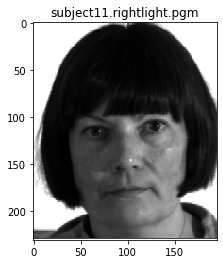

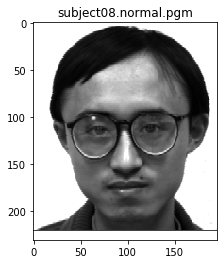

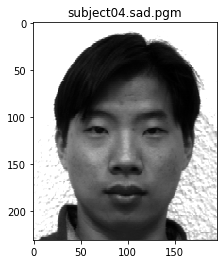

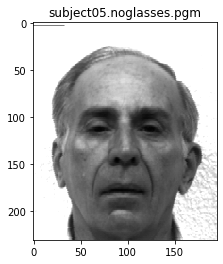

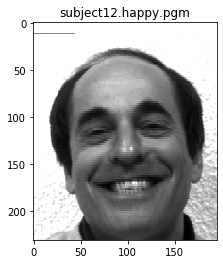

In [7]:
data_folder = "YALE"
file_list = os.listdir(data_folder)
# print(file_list)
sample_images = sample(file_list,10) ## Sample 10 images from the dataset
for img_name in sample_images:
    image_path = os.path.join(data_folder,img_name)
    image = mpimg.imread(image_path)
    plt.imshow(image,cmap="gray")
    plt.title(img_name)
    plt.show()

**Divide the dataset into training and testing sets**

In [8]:
cwd = os.getcwd()
train_folder_path = os.path.join(cwd,"Faces_Train")
test_folder_path = os.path.join(cwd,"Faces_Test")


if not os.path.exists(train_folder_path):
    os.mkdir(train_folder_path)  ## Creates a new directory

if not os.path.exists(test_folder_path):
    os.mkdir(test_folder_path) ## Creates a new directory


idx_list = [str(i).zfill(2) for i in range(1,16,1)] ##Creates numbers with leading zeros(i.e. 01 instead of 1, 02 instaed of 2 etc.)

file_name_list = [[] for i in range(15)]

for i in range(len(idx_list)):
    for fname in file_list:
        if fname.startswith("subject"+idx_list[i]):
            file_name_list[i].append(os.path.join(data_folder,fname))

#print(file_name_list)

for i in range(len(idx_list)):
    ls = file_name_list[i]  ## Finds a list within the 'file_name_list',which contains the paths to images of a particular subject
    
    ## Since a single list contains paths to the images of a particular subject and each subject has 11 images, we will randomly choose an index between 0 and 11
    test_idx = np.random.choice(11)  
    test_file = ls[test_idx]
    shutil.copy(test_file,test_folder_path)
    
    ls.remove(ls[test_idx])
    
    for train_file in ls:
        shutil.copy(train_file,train_folder_path)

**Find eigen-vectors**

In [9]:
train_files_list = os.listdir(train_folder_path)
train_ls = []
for file in train_files_list:
    img_file = os.path.join(train_folder_path,file)
    arr = mpimg.imread(img_file)
    arr = arr.reshape(1,arr.shape[0]*arr.shape[1]) ## Convert to a 1D matrix
    train_ls.append(np.ravel(arr)) ## Before appending, convert the 1D martix to a 1d array using np.ravel 
train_mat = np.matrix(train_ls)
print(train_mat.shape)
mean_img = np.mean(train_mat,axis=0)
print(mean_img.shape)
cov = np.cov(train_mat)
print(cov.shape)
eig_val,eig_vec = np.linalg.eig(cov)

(165, 45045)
(1, 45045)
(165, 165)


Let the data matrix X be of n×p size, where n is the number of samples and p is the number of variables. Let us assume that it is centered, i.e. column means have been subtracted and are now equal to zero.

Then the p×p covariance matrix C is given by $C=(X^⊤X)/n$. It is a symmetric matrix and so it can be diagonalized:
$C=VLV^⊤$,
where $V$ is a matrix of eigenvectors (each column is an eigenvector) and $L$ is a diagonal matrix with eigenvalues $λi$ in the decreasing order on the diagonal. The eigenvectors are called principal axes or principal directions of the data. Projections of the data on the principal axes are called principal components, also known as PC scores; these can be seen as new, transformed, variables. The j-th principal component is given by j-th column of XV. The coordinates of the i-th data point in the new PC space are given by the i-th row of XV.

If we now perform singular value decomposition of X, we obtain a decomposition
$X=USV^⊤$,
where $U$ is a unitary matrix and $S$ is the diagonal matrix of singular values $s_{i}$. From here one can easily see that
$C=VS(U^⊤U)SV^⊤/n= \frac{VS^2V^⊤}{n} $

Singular Values and Singular Vectors

The square roots of the $n$ eigenvalues of $A^T A$ are the singular values of $A$. Since $A^T A$ is symmetric and positive semidefinite, the singular values are real and nonnegative. This lets us write them in sorted order $0 \leq \sigma_n \leq \cdots \leq \sigma_1$.

The $n$ eigenvectors of $A^T A$ are called (right) singular vectors. We denote them by $v_1,\ldots,v_n$, where $v_i$ is the eigenvector for eigenvalue $\sigma_i^2$. The $m$ by $m$ matrix $AA^T$ is also symmetric positive semidefinite. Its largest $n$ eigenvalues are identical to those of $AA^T$, and the rest are zero. The $m$ eigenvectors of $AA^T$ are called (left) singular vectors. We denote them by $u_1,\ldots,u_m$, where $u_1$ through $u_n$ are eigenvectors for eigenvalues $\sigma_1^2$ through $\sigma_n^2$, and $u_{n+1}$ through $u_{m}$ are eigenvectors for the zero eigenvalue. The singular vectors can be chosen to satisfy the identities $Av_i = \sigma_i u_i$ and $A^T u_i = \sigma_i v_i$ for $i=1,\ldots,n$, and $A^Tu_i = 0$ for $i=n+1,\ldots,m$.

**Find the right singular vectors**

In [10]:
eigen_vec_ls = []
#eig1 = train_mat.T@eig_vec[:,0]
#print(eig1.shape)
for i in range(eig_vec.shape[1]):
    eig1 = train_mat.T@eig_vec[:,i]
    eig1 = eig1/eig_val[i]
    eigen_vec_ls.append(np.ravel(eig1))
#print(eigen_vec_ls)

**Find the principal components**

In [11]:
sort_idx = np.argsort(eig_val) ## indices for eigenvalues which are in ascending order
sort_idx = sort_idx[::-1]

eig_val_sum = np.sum(eig_val)
temp_sum = 0
principal_eig_vec = []
principal_eig_val = []
i=0
while(temp_sum<0.95*eig_val_sum):
    principal_eig_vec.append(eigen_vec_ls[sort_idx[i]])
    principal_eig_val.append(eig_val[sort_idx[i]])
    temp_sum += eig_val[sort_idx[i]]
    i += 1
print("Number of components is {}".format(i))

Number of components is 34


In [12]:
Q_hat = np.matrix(principal_eig_vec)

**Visualize the Eigen faces**

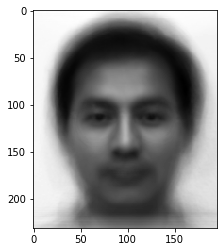

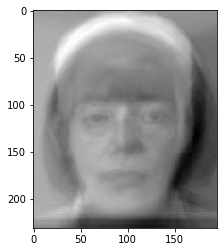

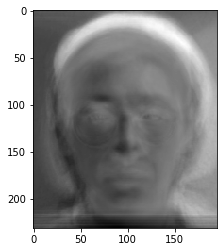

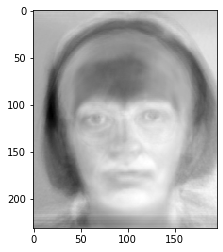

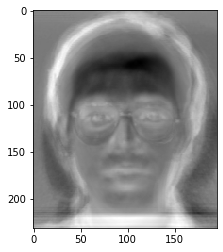

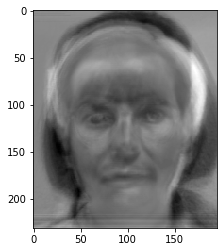

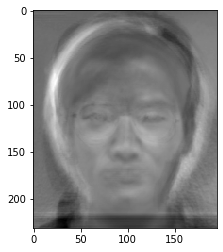

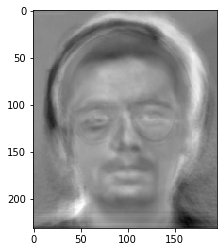

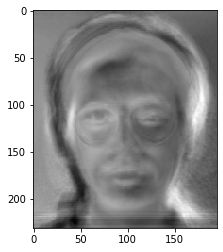

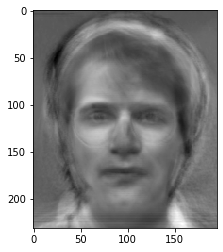

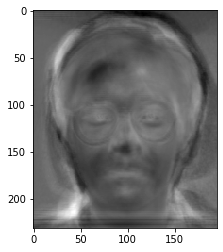

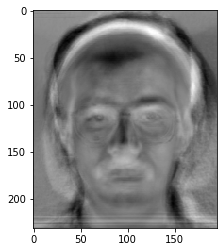

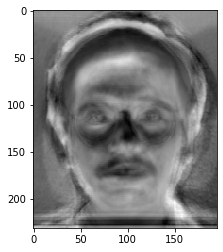

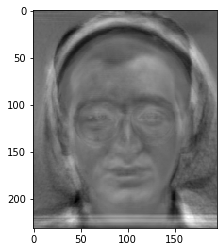

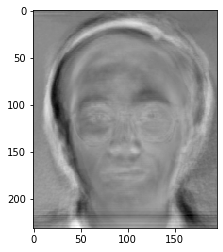

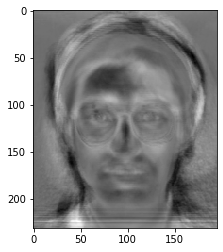

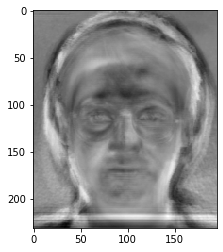

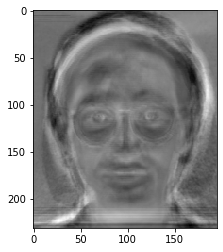

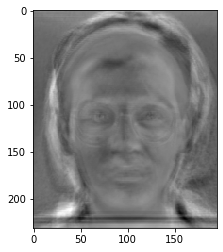

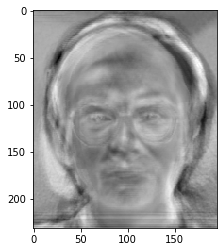

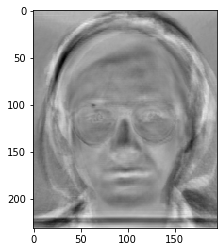

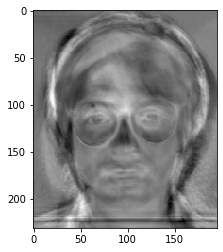

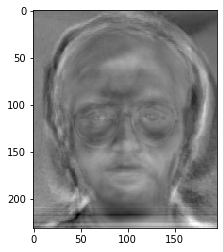

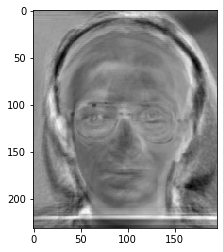

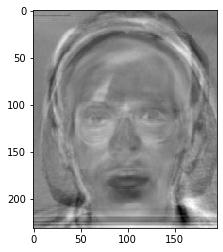

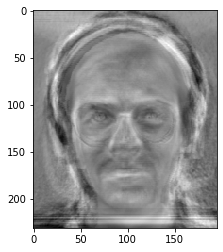

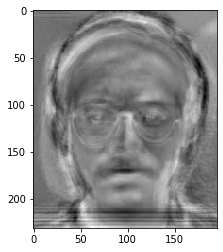

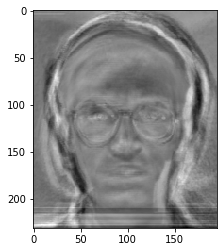

In [13]:
for i in range(28):
    comp_vec = principal_eig_vec[i]
    comp_img = comp_vec.reshape(231,195)
    comp_img = comp_img.astype(float)
    plt.imshow(comp_img,cmap="gray")
    plt.show()

**Draw the Scree Plot**

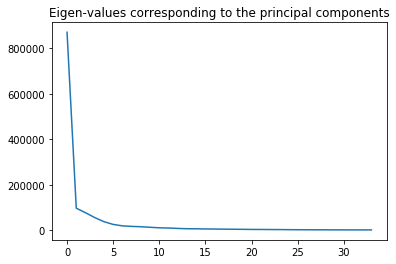

In [14]:
fig, ax = plt.subplots()

ax.plot(principal_eig_val)
ax.set_title("Eigen-values corresponding to the principal components")

plt.show()

**Obtain the feature vectors**

In [15]:
test_files = os.listdir(test_folder_path)
feat_vec_ls = []
for file in test_files:
    img_file = os.path.join(test_folder_path,file)
    test_img = mpimg.imread(img_file)
    test_img = test_img.reshape(arr.shape[0]*arr.shape[1],1)
    test_img = test_img - mean_img.T
    #print(np.linalg.pinv(Q_hat).shape,test_img.shape)
    feat_vec = np.linalg.pinv(Q_hat).T@test_img
    feat_vec_ls.append(np.ravel(feat_vec))

**Obtain the stem plot for the feature vectors**

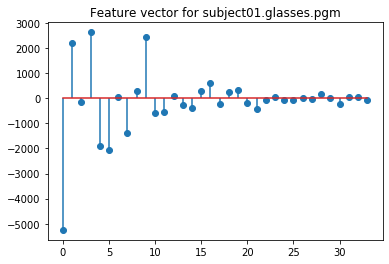

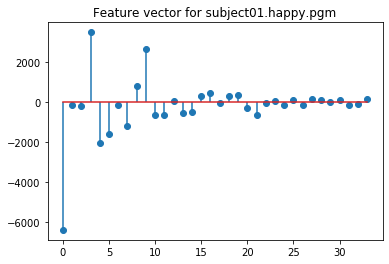

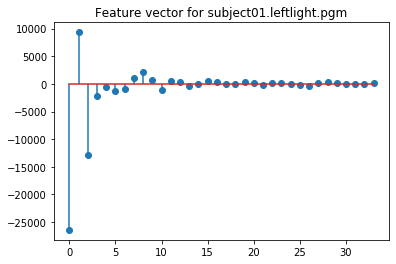

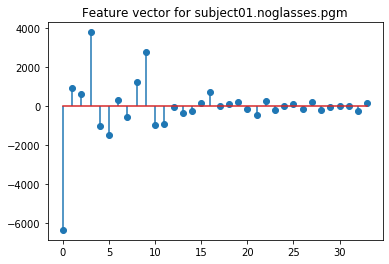

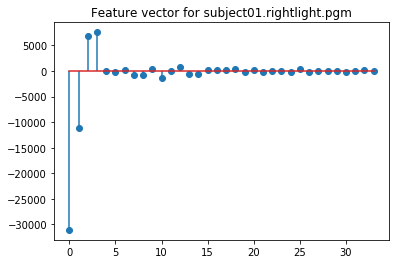

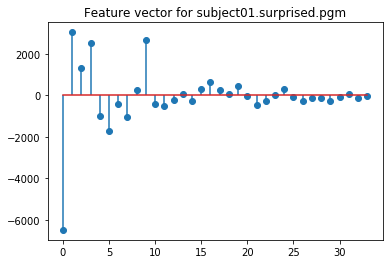

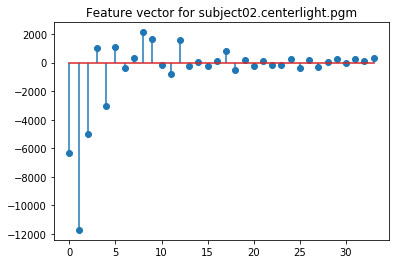

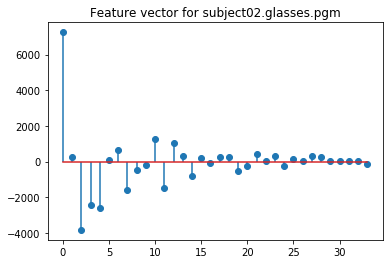

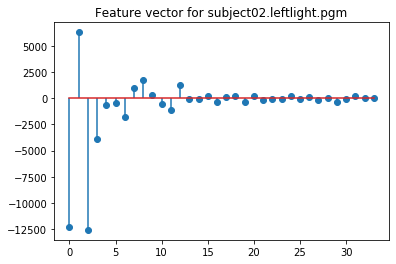

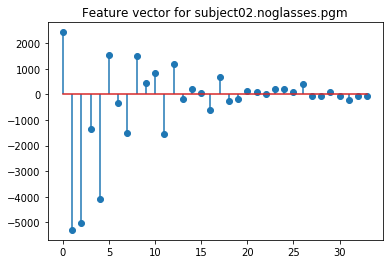

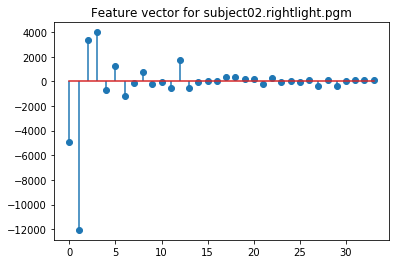

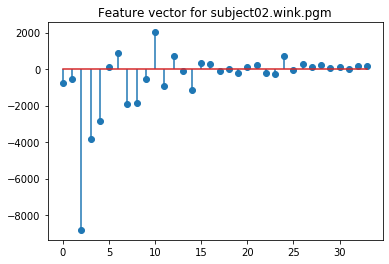

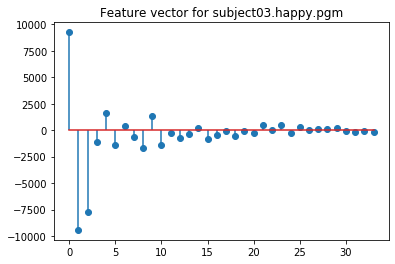

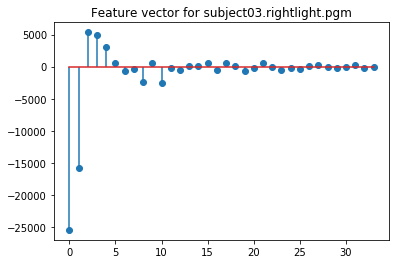

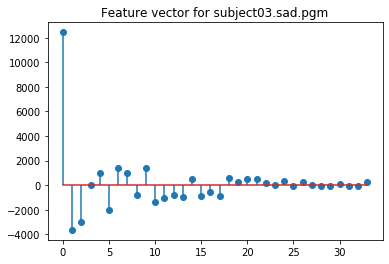

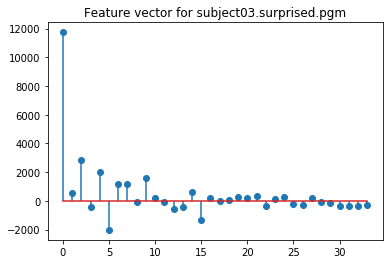

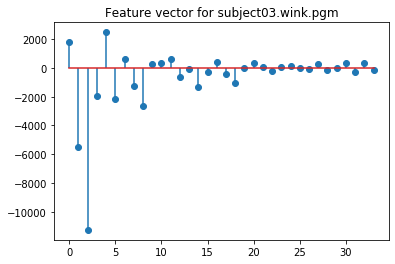

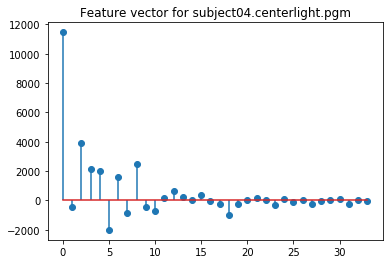

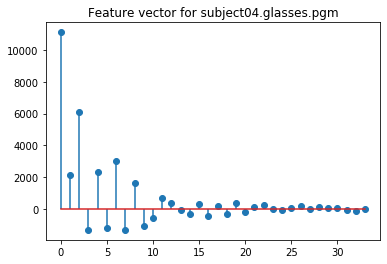

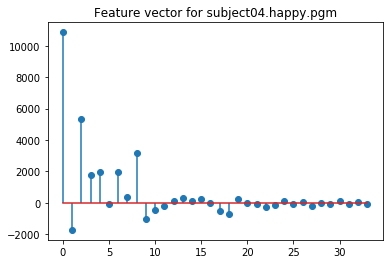

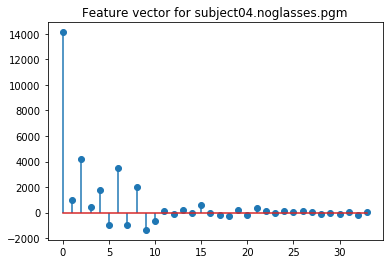

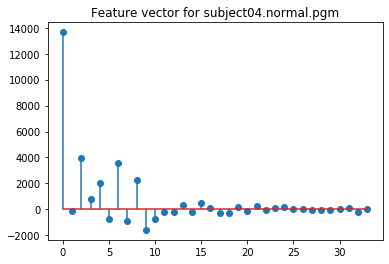

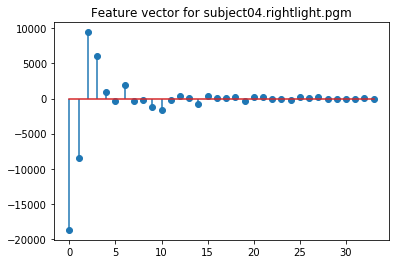

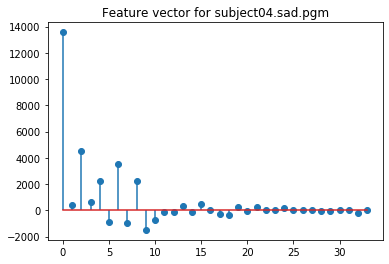

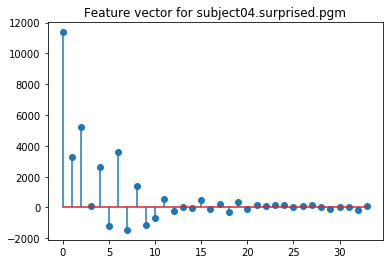

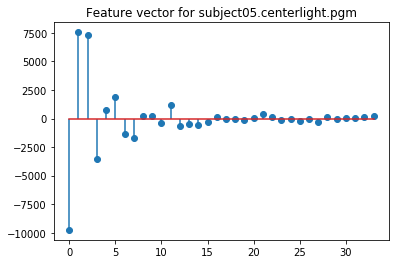

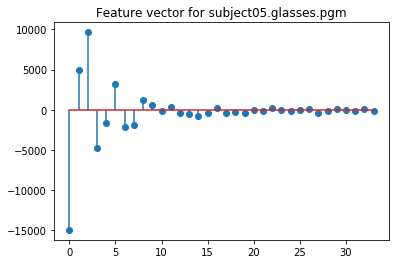

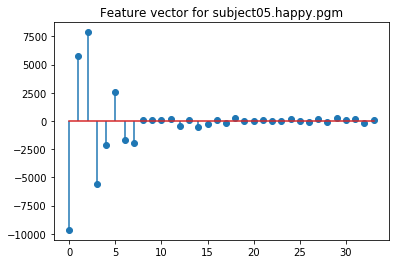

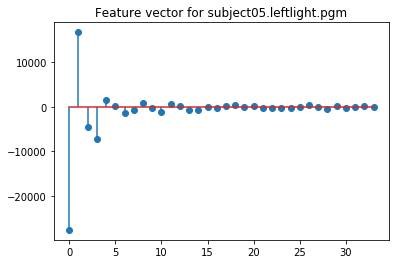

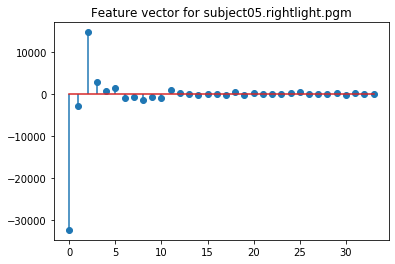

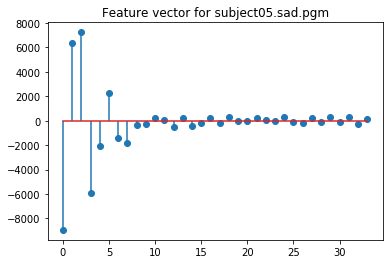

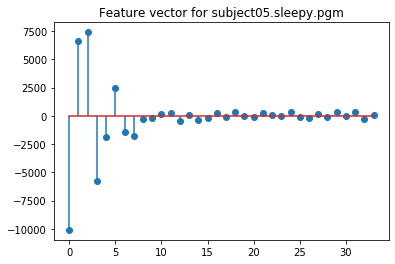

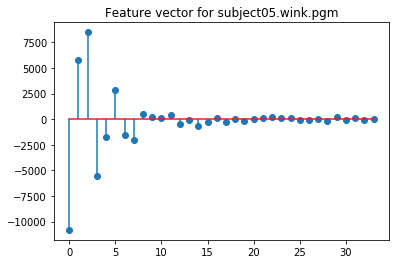

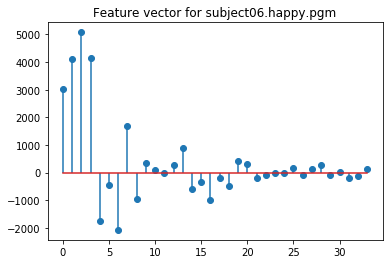

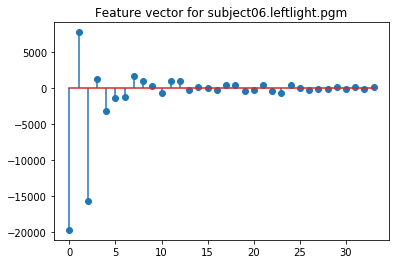

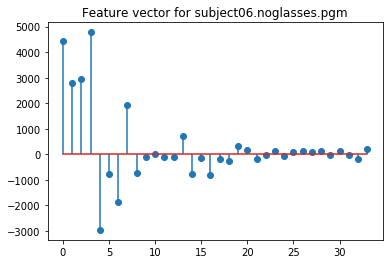

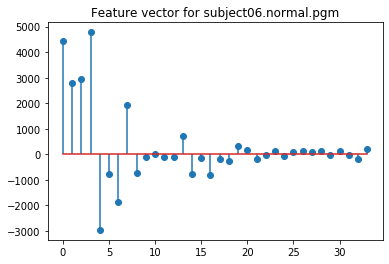

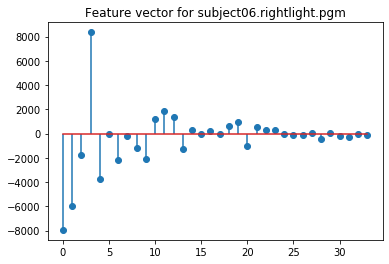

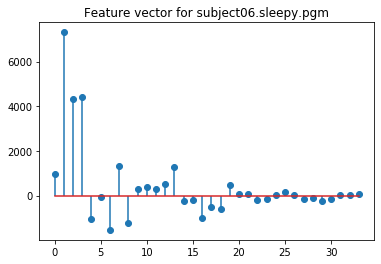

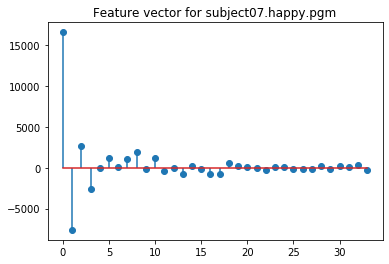

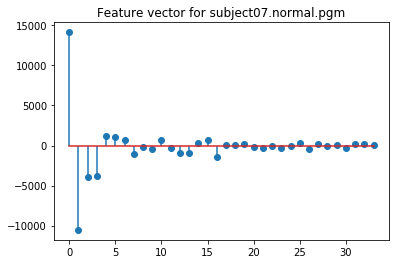

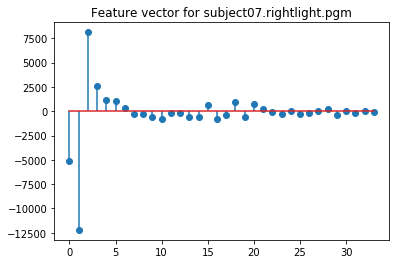

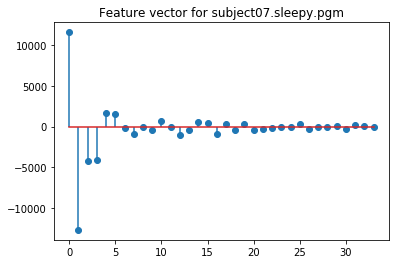

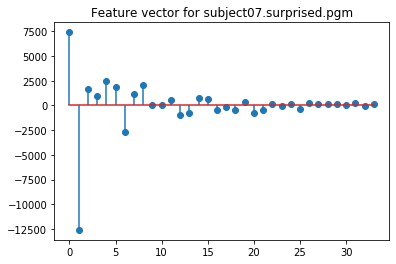

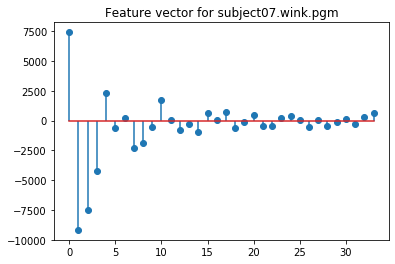

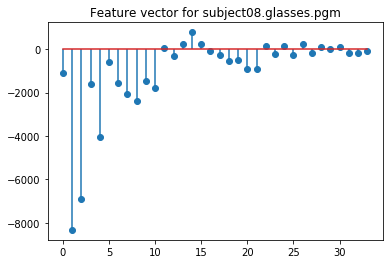

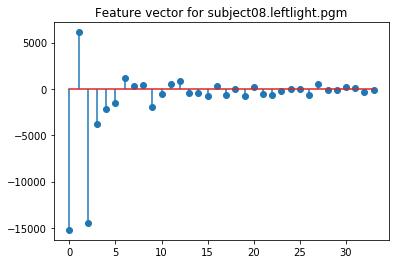

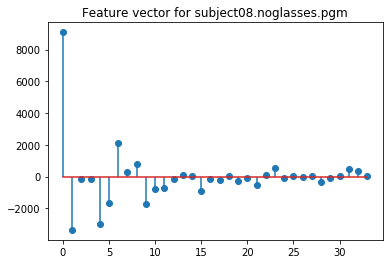

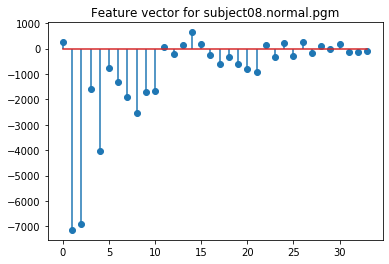

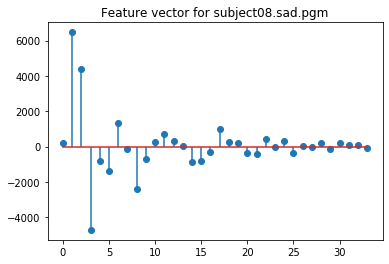

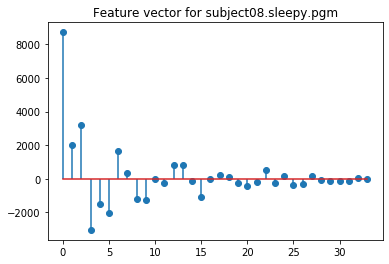

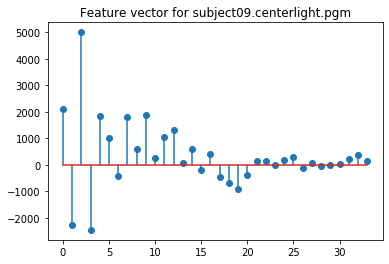

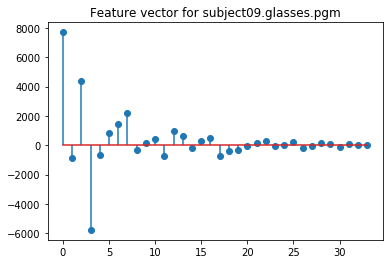

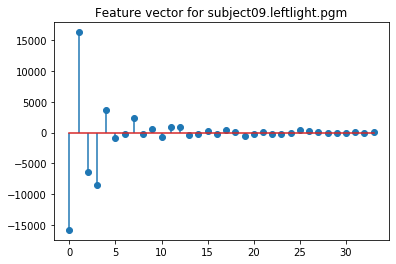

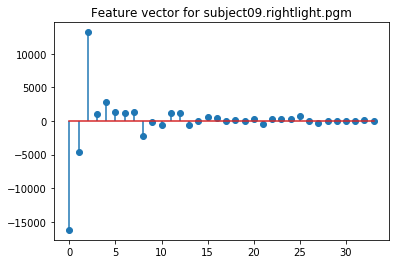

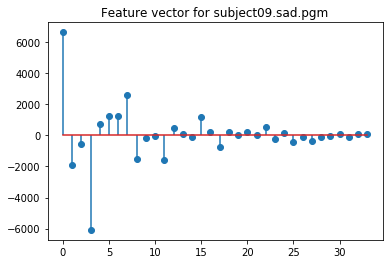

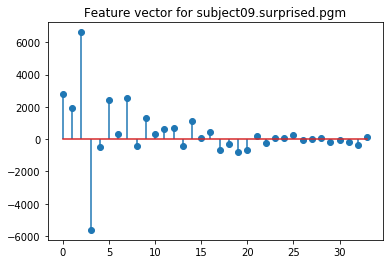

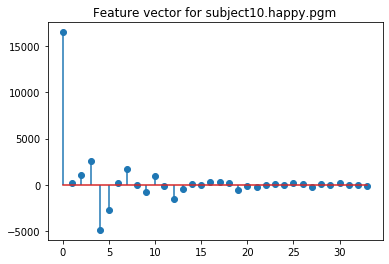

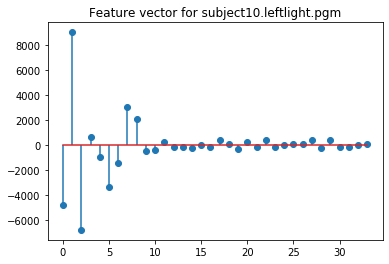

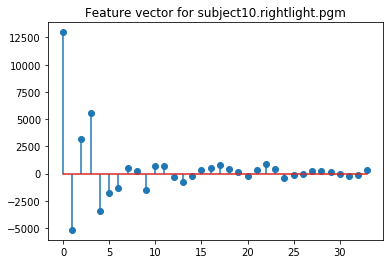

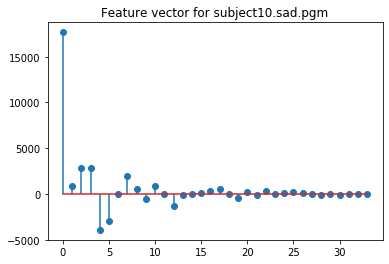

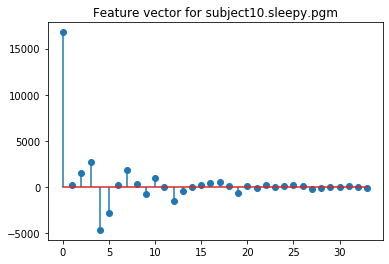

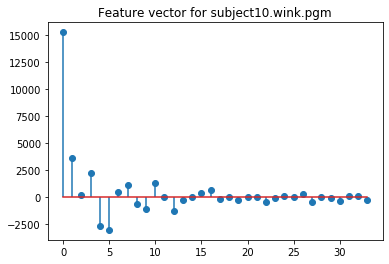

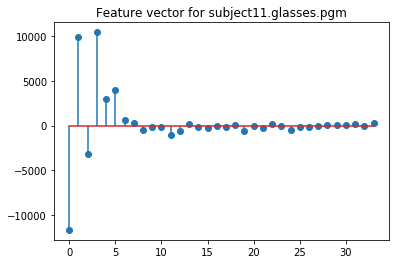

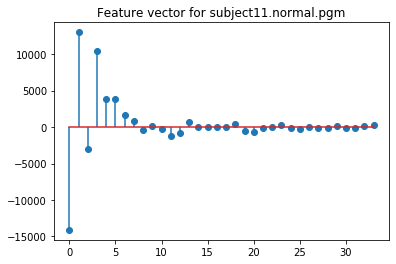

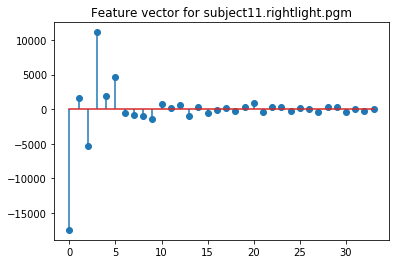

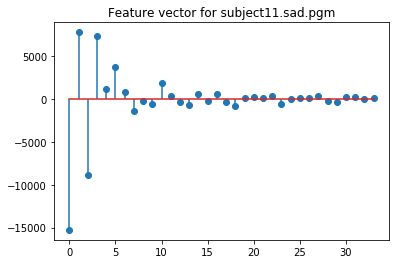

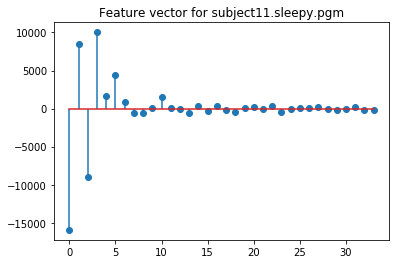

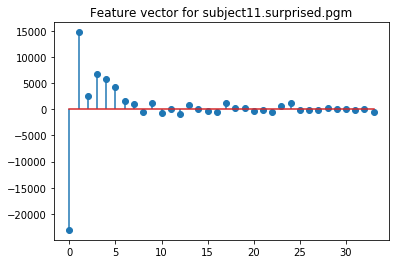

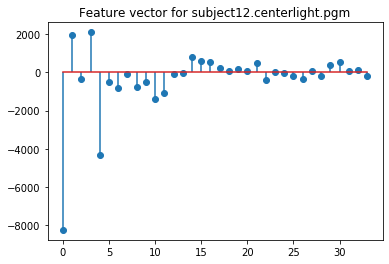

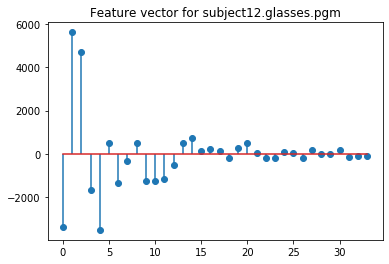

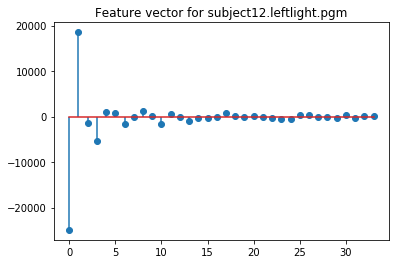

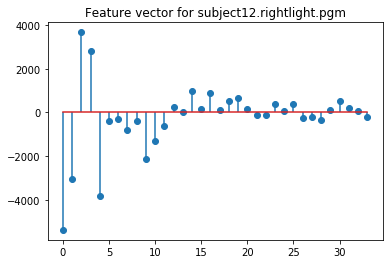

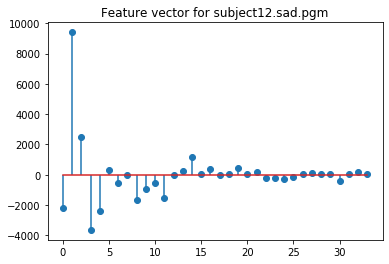

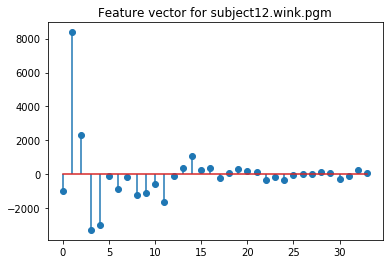

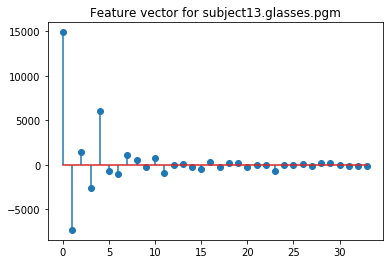

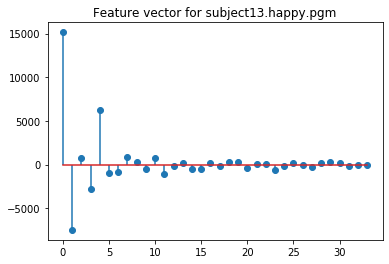

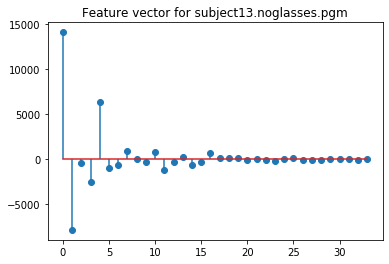

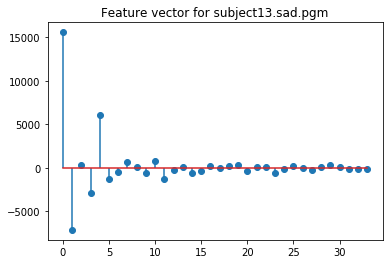

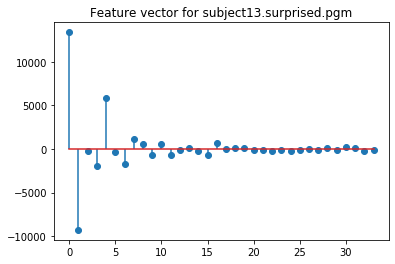

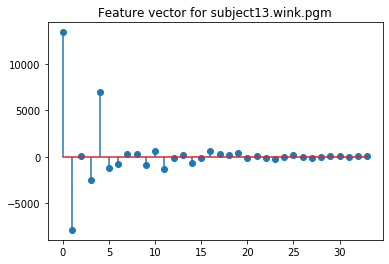

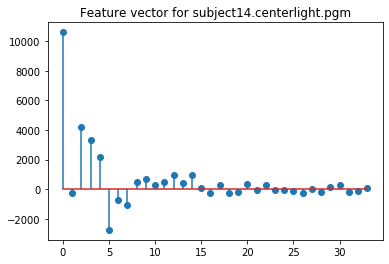

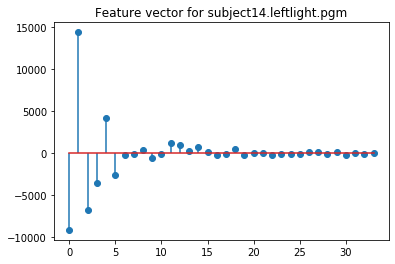

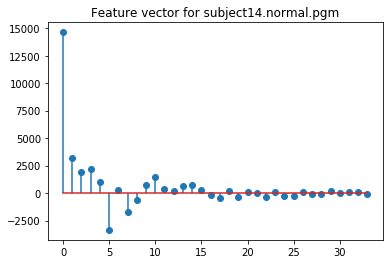

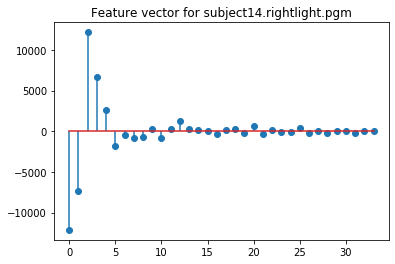

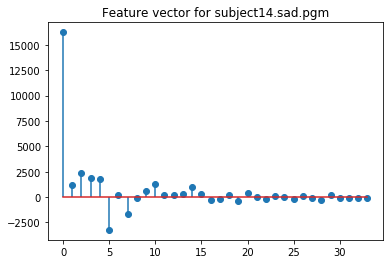

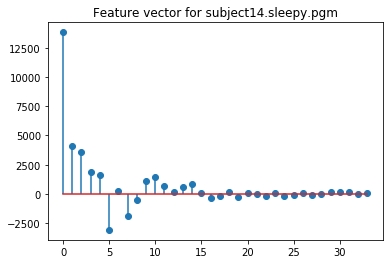

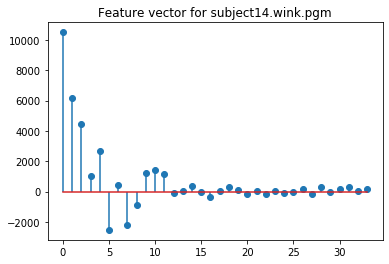

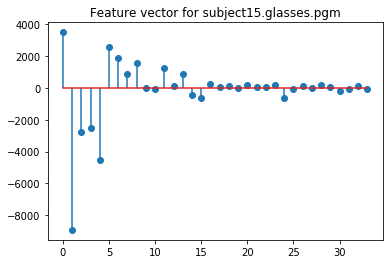

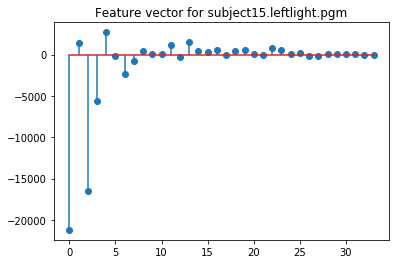

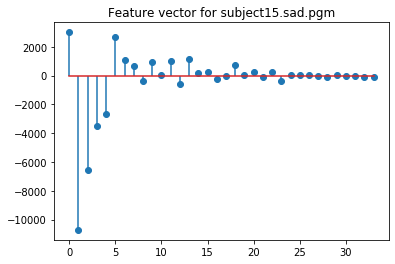

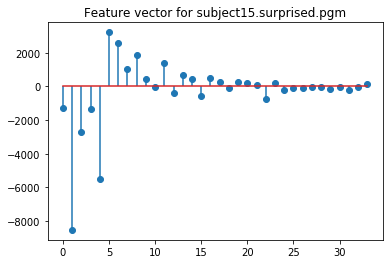

In [16]:
for i in range(len(feat_vec_ls)):
    plt.stem(feat_vec_ls[i],use_line_collection=True)
    plt.title("Feature vector for "+test_files[i])
    plt.show()

---
## PCA using sklearn library

In [17]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
iris = load_iris()
X = iris.data
y = iris.target
print(X.shape)

(150, 4)


In [18]:
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)
print(X_transformed.shape)

(150, 2)
